---
title: "Decision Trees"
author: Daniel Redel
date: today
format:
  html:
    toc: true
    code-fold: false
    html-math-method: katex
jupyter: python3
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

**Decision trees** are nonlinear graphical models that have found important applications in machine learning mainly due to their interpretability as well as their roles in other powerful models such as random forests and gradient boosting regression trees that we will see in the next section.

Decision Trees involve segmenting the predictor space $\textbf{X}$ into a number of **simple rectangular regions**. Unlike linear models that result in linear decision boundaries, decision trees partition the feature space into **hyper-rectangular decision regions** and, therefore, they are _nonlinear models_. 

In this chapter we describe the principles behind training a popular type of decision trees known as **CART** (short for _Classification and Regression Tree_). 

# Regression Trees

A regression tree consists of a series of splitting rules, starting at the top of the tree. Roughly speaking, there are **two steps**:

1. We ***divide the predictor space*** —set of possible values for $X_1, X_2,...,X_p$ — into $J$ distinct and ***non-overlapping regions***, $R_1, R_2,...,R_J$.
2. For every observation that falls *into the region $R_j$*, ***we make the same prediction***, which simply ***the mean of the response values*** for the training observations in $R_j$.

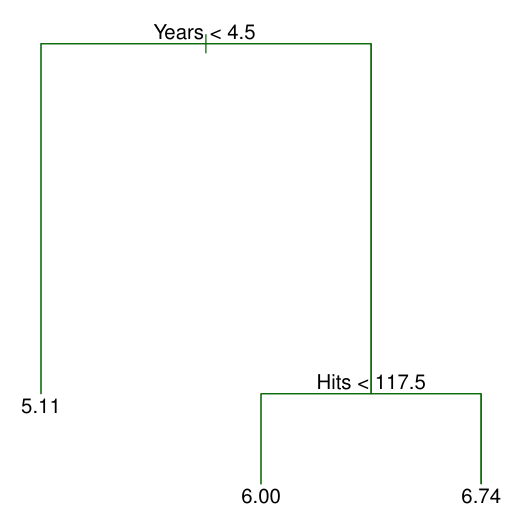

In this example, The top split assigns observations having `Years<4.5` to the left branch. This first region can be written as $R_1=(X|\text{Years<4.5})$.

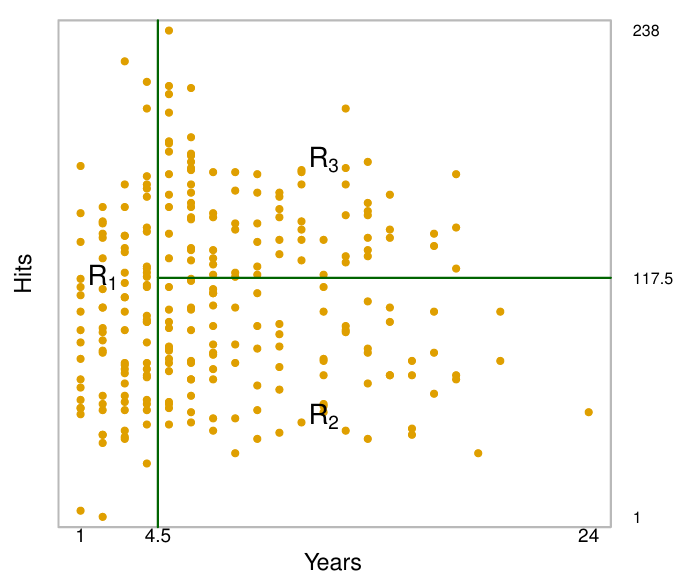

- The regions $R_1$, $R_2$, and $R_3$ are known as terminal nodes or leaves of the tree.
- The points along the tree where the predictor space is split are referred to as internal nodes.
- At a given internal node, the label of the form $X_j < t_k$ indicates the left-hand branch emanating from that split, and the right-hand branch corresponds to $X_j ≥ t_k$.

## Recursive Binnary Splitting

**How do we construct the regions $R_1,...,R_J$?** The goal is to **find boxes** $R_1,...,R_J$ that ***minimize the $\text{RSS}$***, given by

$$
\sum^J_{j=1}\sum_{i \in R_j} (y_i-\hat{y}_{R_j})^2
$$

- where $\hat{y}_{R_j}$ is the mean response within the $j$ th box.

> *Unfortunately, it is **computationally infeasible** to consider **every possible partition** of the feature space into $J$ boxes.*

💡 For this reason, we take a *top-down*, ***greedy approach*** that is known as ***recursive binary splitting***.

1. **Top-Down**: The approach is ***top-down*** because ***it begins at the top of the tree*** and then ***successively splits the predictor space***; each split is indicated via two new branches further down on the tree. 
2. **Greedy**: It is ***greedy*** because at each step of the tree-building process, the ***best split is made*** at that particular step, *rather than looking ahead and picking* a split that will lead to a better tree in some future step.

*Because we do this **sequential** for every internal node, the algorithm is called recursive binary splitting.*

> **Step 1: *Select $X_j$ and $s$ (Find partitions) that leads to greatest reduction in $\text{RSS}$***

- In order to perform **recursive binary splitting**, we **first** select the predictor $X_j$ **and** the cutpoint $s$ such that *splitting the predictor space into the regions* $(X|X_j<s)$ and $(X|X_j\geq s)$ ***leads to the greatest possible reduction in $\text{RSS}$.***
- The **notation** $(X|X_j<s)$ means *the Region $R_1(j,s)$ of predictor space in which $X_j$ takes on a value less than $s$*. Thus, we choose ***the predictor $X_j$ and cutpoint $s$ such that the resulting tree has the lowest RSS.***

> **Step 2**: Select $X_j$ and $s$ that leads to even greatest reduction in $\text{RSS}$ **within** each of the **already identified regions**.

- Next, we repeat the process, looking for the best predictor $X_j$ and best cutpoint $s$ in order to split the data further so as to minimize the $\text{RSS}$ within each of the **resulting regions**.

> **Step 3**: The process continues until a **stopping criterion** is reached. 

- For instance, we may continue until no region contains more than 5 observations.

> **Step 4**: Predict Responses in Test Sample.

- Once the regions $R_1,...,R_J$ have been created, we predict the response for a given test observation **using the mean** of the training observations in the region to which that test observation belongs.

## Tree Prunning

**Challenge**: good predictions on the training set, but likely to overfit the data, leading to poor test set performance. This is because _**the resulting tree might be too complex**_. A smaller tree with fewer splits might lead to lower variance and better interpretation at the cost of a little bias.

> **Solution**: Therefore, a better strategy is to grow _a very large tree_ $T_0$, and then **prune it back in order to obtain a subtree**(Backward Stepwise). 

**Cost Complexity Pruning:** Rather than considering every possible subtree, we consider a sequence of trees indexed by a nonnegative tuning parameter $α$. For each value of $\alpha$ there corresponds a subtree $T\in T_0$ such that:

$$
\sum^{\lvert T \rvert}_{M=1}\sum_{i:x_i\in R_m}(y_i-\hat{y}_{R_m})^2+a\lvert T \rvert
$$

is as small as possible. 

- Here $\lvert T\rvert$ indicates the ***number of terminal nodes of the tree*** $T$
- $R_m$ is the rectangle (the **subset** of predictor space) corresponding to the $m$ th terminal node, ***and $\hat{y}_{R_m}$ is the predicted response associated with $R_m$***—that is, the mean of the training observations in $R_m$.

💡 The tuning parameter $α$  controls a ***trade-off between*** the *subtree’s complexity* and its *fit to the training data*.

1. When $α = 0$, then the subtree $T=T_0$.
2. As $α$ increases, there is a ***price to pay for having a tree with many terminal nodes***.

💡 We can select a value of $α$ using a validation set or using ***cross-validation***. We then return to the full data set and obtain the subtree corresponding to $α$.


## Model Training

Here we fit a regression tree to the `Boston` data set. The steps are similar to those for classification trees.

In [6]:
#| label: tbl-raw-dataset
#| tbl-cap: Boston  Dataset
#| code-fold: true
from ISLP import load_data, confusion_table
df = load_data("Boston")

df.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor as DT

# Target vs Inputs
X = df.drop(columns=["medv"]) # Covariates-Only
y = df["medv"] # Target-Outcome

# Train vs Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize Decision Tree Regressor
dtree = DT(random_state=0)

# Train Model
dtree.fit(X_train, y_train)

# Predict
y_test_pred = dtree.predict(X_test)

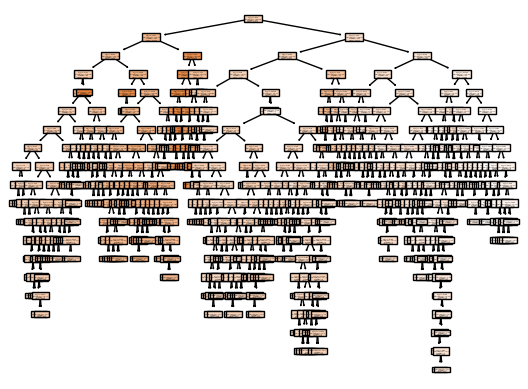

In [8]:
#| label: fig-ctree1
#| fig-cap: Full Classification Tree
#| code-fold: true

from sklearn import tree
my_tree = tree.plot_tree(dtree, filled=True)

In [9]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('R2 Train' , dtree.score(X_train, y_train).round(2) ) 
print('R2 Test' , dtree.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, y_test_pred).round(2) )

R2 Train 1.0
R2 Test 0.58
Test MSE: 34.04


As expected, the accuracy on the training set is 100% —because the leaves are pure, the tree was grown deep enough that it could perfectly memorize all the labels on the training data. The test set accuracy is a lot worse than for the linear models we looked at previously, which had around 58% accuracy. 

Unpruned trees are therefore prone to **overfitting** and not generalizing well to new data. Now let’s apply pruning to the tree.

### Tree Pruning

We use the full tree we already built (`dtree`) to then run the `cost_complexity_pruning_path()` method of `dtree` to extract cost-complexity values:

In [23]:
import sklearn.model_selection as skm

ccp_path = dtree.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=10)

Optimal Alpha: -15.28


This yields a set of impurities and $\alpha$ values from which we can extract an optimal one by cross-validation (`GridSearchCV`):

In [ ]:
# Grid Search
grid = skm.GridSearchCV(dtree, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='neg_mean_squared_error')

# Fit Model
G = grid.fit(X_train, y_train)

# Best
best_ = grid.best_estimator_

print('Optimal Alpha:', grid.best_score_.round(2))

Let’s plot the best tree to see how interpretable it is now:

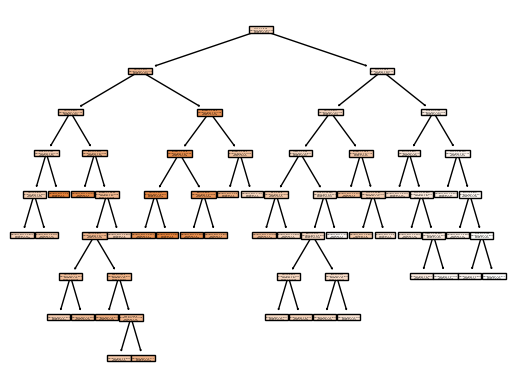

In [22]:
#| label: fig-ctree2
#| fig-cap: Pruned Classification Tree
#| code-fold: true

from sklearn import tree
column_names = X.columns.tolist()

best_ = G.best_estimator_
my_tree = tree.plot_tree(best_, feature_names=column_names, filled=True)

In keeping with the cross-validation results, we use the pruned tree to make predictions on the test set:

In [25]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('R2 Train' , best_.score(X_train, y_train).round(2) ) 
print('R2 Test' , best_.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, best_.predict(X_test)).round(2) )

R2 Train 0.95
R2 Test 0.61
Test MSE: 31.83


 In other words, the test set MSE associated with the regression tree is 31.8. Prunning the tree decreases overfitting. This leads to a lower accuracy on the training set, but an improvement on the test set.

### Feature Importance

In [89]:
feat_importance = best_.tree_.compute_feature_importances(normalize=False)
column_names = X.columns.tolist()
fimp_df = pd.DataFrame(feat_importance, column_names).reset_index().sort_values(0, ascending=False).head(10)

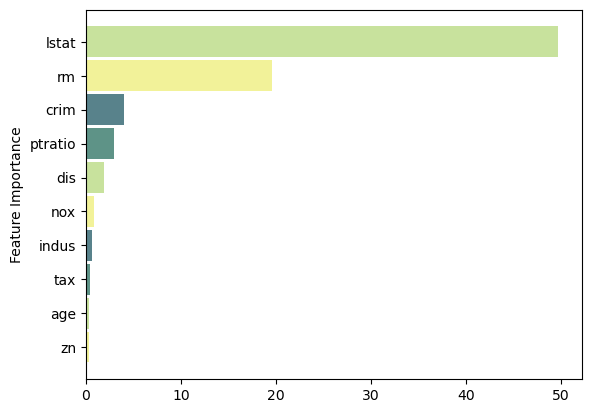

In [88]:
#| label: fig-feat-imp
#| fig-cap: Feature Importance Classification Tree
#| code-fold: true

fig, ax = plt.subplots()

# Setup
data = fimp_df.loc[:,0].sort_values()
index = np.arange(data.shape[0])
bar_labels = fimp_df.sort_values(0).loc[:,'index'].tolist()
bar_colors = ['#F2F299', '#C8E29D', '#5E9387', '#58828B']
bar_width = 0.9

# Figure
ax.barh(index, data, bar_width, label=bar_labels, color=bar_colors)

# Labels
ax.set_ylabel('Feature Importance')
ax.set_yticks(index, labels=bar_labels)

# Show
plt.show()

# Classification Trees

> For a **classification tree**, we predict that each observation belongs to the **most commonly occurring class** of training observations in the region to which it belongs. 

Just as in the regression setting, we use **recursive binary splitting** to grow a classification tree. 

However, in the classification setting, ***RSS cannot be used** as a **criterion** for making the **binary splits**.* So, we need to find another Impurity Measure for classification problems.


## Impurity Measures

There are some common measures of impurity that satisfy these requirements. Common choices include **Gini**, **Entropy**, and **Misclassification Error** (if we classify all observations in S to the majority class) given by:

$$
\text{Gini Index: } G=\sum^K_{k=1} \hat{p}_{mk}(1-\hat{p}_{mk}) \\
\text{Entropy: } D=-\sum^K_{k=1} \hat{p}_{mk}\log(\hat{p}_{mk}) \\
\text{Error Rate: } E=1-\max_k(\hat{p}_{mk})
$$

In fact, it turns out that the Gini index and the entropy are quite similar numerically. When building a classification tree, either the **Gini index** or the **entropy** are typically used to evaluate the quality of a particular split, since these two approaches are more sensitive to node purity than is the classification error rate. 

## Model Training

In [90]:
#| label: tbl-raw-dataset1
#| tbl-cap: Breast Cancer Dataset
#| code-fold: true
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
# Add target
df['target'] = cancer.target

df.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier as DT

# Target vs Inputs
X = df.drop(columns=["target"]) # Covariates-Only
y = df["target"] # Target-Outcome

# Train vs Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize Decision Tree Regressor
dtree = DT(random_state=0)

# Train Model
dtree.fit(X_train, y_train)

# Predict
y_test_pred = dtree.predict(X_test)

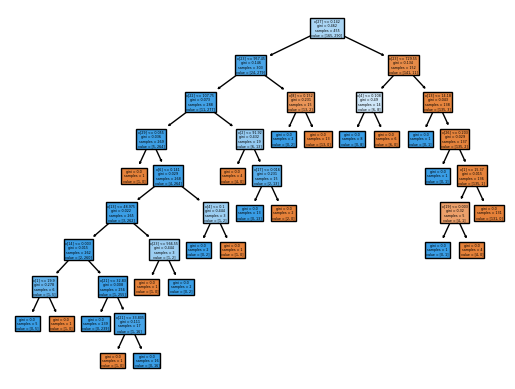

In [93]:
#| label: fig-rtree
#| fig-cap: Full Regression Tree
#| code-fold: true

from sklearn import tree
my_tree = tree.plot_tree(dtree, filled=True)

In [94]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('R2 Train' , dtree.score(X_train, y_train).round(2) ) 
print('R2 Test' , dtree.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, y_test_pred).round(2) )

R2 Train 1.0
R2 Test 0.91
Test MSE: 0.09


As expected, the accuracy on the training set is 100% —because the leaves are pure, the tree was grown deep enough that it could perfectly memorize all the labels on the training data. The test set accuracy is worse. Let's try to improve it through Pruning.

### Tree Prunning

We first **refit the full tree** on the training set; here we do not set a `max_depth` parameter, since we will learn that through cross-validation.

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier as DT

# Train vs Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize Decision Tree Regressor
dtree = DT(random_state=0)

# Train Model
dtree.fit(X_train, y_train)

# Predict
y_test_pred = dtree.predict(X_test)

Next we use the `cost_complexity_pruning_path()` method of `dtree` to extract cost-complexity values:

In [96]:
import sklearn.model_selection as skm

ccp_path = dtree.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10, random_state=1, shuffle=True)

This yields a set of impurities and $\alpha$ values from which we can extract an optimal one by cross-validation (`GridSearchCV`):

In [97]:
grid = skm.GridSearchCV(dtree,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True, cv=kfold, scoring='accuracy')

grid.fit(X_train, y_train)

print('Optimal Alpha:', grid.best_score_.round(2))

Optimal Alpha: 0.93


Let’s take a look at the pruned true:

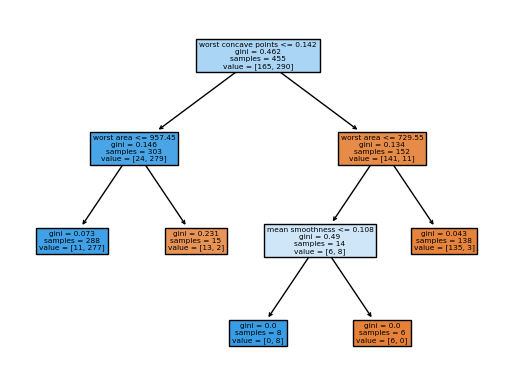

In [98]:
#| label: fig-rtree1
#| fig-cap: Pruned Regression Tree
#| code-fold: true

from sklearn import tree
column_names = df.drop(columns='target').columns.tolist()
best_ = grid.best_estimator_
my_tree = tree.plot_tree(best_, feature_names=column_names, filled=True)

We could count the leaves, or query `best_` instead.

In [99]:
best_.tree_.n_leaves

5

In [100]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('Accuracy Train' , best_.score(X_train, y_train).round(2) ) 
print('Accuracy Test' , best_.score(X_test, y_test).round(2) ) 
print( 'Test MSE:', mean_squared_error(y_test, best_.predict(X_test)).round(2) )

Accuracy Train 0.96
Accuracy Test 0.97
Test MSE: 0.03


In [101]:
#| label: tbl-cf1
#| tbl-cap: Confusion Matrix
#| code-fold: true

from ISLP import load_data, confusion_table

confusion = confusion_table(best_.predict(X_test), y_test)
confusion

Truth,0,1
Predicted,,
0,45,1
1,2,66


Pruning the tree clearly help the performance of our tree classifier.

### Feature Importance

In [109]:
feat_importance = best_.tree_.compute_feature_importances(normalize=False)
column_names = df.drop(columns='target').columns.tolist()

fimp_df = pd.DataFrame(feat_importance, column_names).reset_index().sort_values(0, ascending=False).head(3)

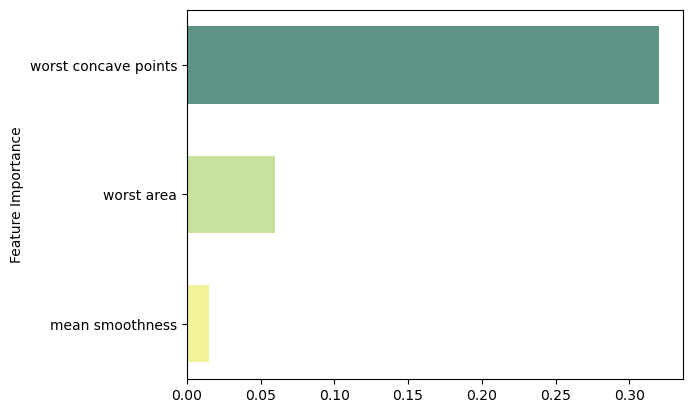

In [112]:
#| label: fig-feat-imp1
#| fig-cap: Feature Importance Regression Tree
#| code-fold: true
fig, ax = plt.subplots()

# Setup
data = fimp_df.loc[:,0].sort_values()
index = np.arange(data.shape[0])
bar_labels = fimp_df.sort_values(0).loc[:,'index'].tolist()
bar_colors = ['#F2F299', '#C8E29D', '#5E9387', '#58828B']
bar_width = 0.6

# Figure
ax.barh(index, data, bar_width, label=bar_labels, color=bar_colors)

# Labels
ax.set_ylabel('Feature Importance')
ax.set_yticks(index, labels=bar_labels)

# Show
plt.show()